In [1]:
from textwrap import dedent, indent

from liblet import (
    Production, 
    Grammar, 
    Derivation, 
    ProductionGraph,
    TopDownInstantaneousDescription,
    Stack,
    Table,
    Tree,
    closure, 
    warn, 
    show_calls, 
    union_of, 
    dod2table, 
    side_by_side,
    dict2table,
    suffixes,
    ε, HASH,
    __version__)

In [2]:
def compute_εfirst(G):

    FIRST = Table(1, element = set) # questo significa che gli elementi dell tabella sono insiemi

    # per prima cosa, il caso banele 
    for t in G.T: FIRST[(t, )] = {t} # attenzione, gli indici sono forme sentenziali, ossia tuple!
        
    # qualche caso "extra" che ci verrà comodo poi    
    FIRST[tuple()] = {ε}
    FIRST[(ε, )] = {ε}
    FIRST[(HASH, )] = {HASH}

    @closure
    def update_with_suffixes(FIRST):
        for N, α in G.P:
            FIRST[(N, )] |= FIRST[α]
            for γ in suffixes(α):
                A, *β = γ
                FIRST[γ] |= FIRST[(A, )] - {ε}
                if ε in FIRST[(A, )]: FIRST[γ] |= FIRST[β]
        return FIRST

    return update_with_suffixes(FIRST)

In [3]:
def compute_follow(G, FIRST):
    
    FOLLOW = Table(1, set)
    FOLLOW[G.S] |= {HASH}
    
    @closure
    def complete_follow(FOLLOW):
        for X, ω in G.P:
            for γ in suffixes(ω): # X -> α A β (α è mangiato dal suffisso)
                A, *β = γ
                if A not in G.N: continue
                FOLLOW[A] |= FIRST[β] - {ε}
                if ε in FIRST[β]: FOLLOW[A] |= FOLLOW[X]
        return FOLLOW
    
    return complete_follow(FOLLOW)

In [4]:
def compute_table(G, FIRST, FOLLOW):
    
    TABLE = Table(2)
    FIRST_TABLE = Table(2)
    FOLLOW_TABLE = Table(2)

    for P in G.P:
        A, α = P
        for a in FIRST[α] - {'ε'}:
            if FIRST_TABLE[A, a] is not None:
                warn('First/first conflict on ({}, {}) for production {}'.format(A, a, P))
            else:
                FIRST_TABLE[A, a] = P
                TABLE[A, a] = P
        if 'ε' in FIRST[α]:
            for a in FOLLOW[A]:
                if FIRST_TABLE[A, a] is not None:
                    warn('First/follow conflict on ({}, {}) for production {}'.format(A, a, P))
                if FOLLOW_TABLE[A, a] is not None:
                    warn('Follow/follow conflict on ({}, {}) for production {}'.format(A, a, P))
                if FIRST_TABLE[A, a] is None and FOLLOW_TABLE[A, a] is None:
                    FOLLOW_TABLE[A, a] = P
                    TABLE[A, a] = P
    return TABLE

In [5]:
def parse(G, TABLE, INPUT):
    tdid = TopDownInstantaneousDescription(G, INPUT)
    while not tdid.is_done():
        if tdid.top() in G.N:
            P = TABLE[tdid.top(), tdid.head()]
            if P is None:
                warn('No production for ({}, {}) at {}.'.format(tdid.top(), tdid.head(), tdid.steps) )
                return None 
            tdid = tdid.predict(P)
        else:
            if tdid.top() == ε or tdid.top() == tdid.head():
                tdid = tdid.match()
            else:
                warn('Expecting {}, got {}.'.format(tdid.top(), tdid.head()))
                return None   
    return Derivation(G).leftmost(tdid.steps)

In [6]:
G = Grammar.from_string("""
E  -> T E'
E' -> + T E' | - T E' | ε
T  -> F T' | ε
T' -> * F T' | / F T'
F  -> ( E ) | t
""")

G = Grammar.from_string("""
S -> Add
Add -> Mul AddAux
AddAux -> + Mul AddAux | - Mul AddAux | ε

Mul -> Fract MulAux
MulAux -> x Fract MulAux | : Fract MulAux | ε

Fract -> Pow FractAux
FractAux -> / Pow FractAux | ε

Pow -> F PowAux
PowAux -> ^ F PowAux | ε
F -> ( Add ) | [ Add ] | { Add } | < Add > | Num

Num -> Digit Num | ε
Digit -> 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 0

""")

G = Grammar.from_string("""
E -> E1 E1T
E1 -> E2 E2T
E1T -> - E1 E1T | + E1 E1T | ε
E2 -> E3 E3T
E2T -> x E2 E2T |: E2 E2T | ε
E3 -> ( E )  | n
E3T -> ^ E3 E3T | ε
""")


FIRST = compute_εfirst(G)
FIRST.restrict_to({(N, ) for N in G.N})
FOLLOW = compute_follow(G, FIRST)
TABLE = compute_table(G, FIRST, FOLLOW)

In [7]:
def derivation_to_parsetree(d):
    root = [{'name': d.G.S}]
    sentence = [root, ] 
    print(d.steps())
    for prod, pos in d.steps():
        tree = sentence[pos]
        children = [[{'name': X}] for X in d.G.P[prod].rhs]
        tree.extend(children)
        children = [child for child in children if child[0]['name'] != 'ε']
        sentence = sentence[:pos] + children + sentence[pos + 1:]
        
    return root

((0, 0), (1, 0), (5, 0), (10, 0), (12, 1), (8, 1), (2, 1), (1, 2), (5, 2), (10, 2), (12, 3), (8, 3), (3, 3), (1, 4), (5, 4), (10, 4), (12, 5), (8, 5), (4, 5))


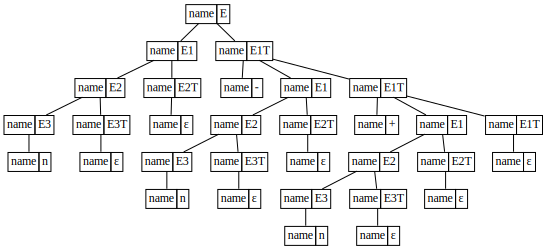

NameError: name 'AtwPtreeToAst' is not defined

In [8]:
ex5b = '3 / < 4 + 2 > + 2 x ( 3 : ( 4 + 5 ) + 2 ^ < 6 x 1 / 2 > ) - < 2 x ( 5 x ( 3 + 4 ) + 5 ) - 1 > / 6'

src = ' n  - n + n'
 
d = parse(G, TABLE, src.split())
pt = derivation_to_parsetree(d)
ptree = Tree.from_lol(pt)
ProductionGraph(d)
display(ptree)

atw_ptree_to_ast = AtwPtreeToAst()
#ast = atw_ptree_to_ast.start(ptree)
#ast

# SDD https://stackoverflow.com/questions/47622118/how-ll1-parser-handle-right-associative-grammar

In [ ]:
ptree

In [ ]:
ex1 = '1 + { 2 x [ ( 3 + 4 : 2 ) + 5 ] x 6 } - [ 7 + ( 1 + 8 ) : 3 ] x [ 9 : ( 2 + 1 ) + 2 ]'
ex2 = '< 2 + 3 > / 4 / < 5 + 6 > / 7'
ex3 = '2 ^ < 3 + 4 ^ 5 : 2 ^ 7 >'
ex4 = '3 + 1 3 x < 1 + 3 > / < 2 ^ < 1 + 4 > - 6 >'
ex5a = '3 / < 4 + 2 > + 2 x { 3 : ( 4 + 5 ) + 2 ^ < 6 x 1/2 > } - < 2 x [ 5 x ( 3 + 4 ) + 5 ] - 1 > / 6'
ex5b = '3 / < 4 + 2 > + 2 x ( 3 : ( 4 + 5 ) + 2 ^ < 6 x 1 / 2 > ) - < 2 x ( 5 x ( 3 + 4 ) + 5 ) - 1 > / 6'

src = ' 8 - 4 + 5'

d = parse(G, TABLE, src.split())
pt = derivation_to_parsetree(d)
ptree = Tree.from_lol(pt)
ProductionGraph(d)
ptree
atw_ptree_to_ast = AtwPtreeToAst()
ast = atw_ptree_to_ast.start(ptree)


AM = ArithManager()

blocks = AM.blocks(ast)
MEMORY = dict(blocks)

main_block = blocks[-1][1]
child_to_calc = None

current_block = block_id = None

while blocks and is_calculable(blocks[0][1]): blocks = blocks[1:]
    
while blocks:
    block_id, current_block = blocks[0]
        
    parent_to_calc = AM.prior(current_block)
    display_latex(AM.latex(main_block, MEMORY))

    parent_to_calc.children =  [Tree({'type': 'atomExpr', 'value': AM.eval(child, MEMORY), 'priority': 0, '_calc': 'last'}, []) 
                                if is_next_to_calc(child) else child
                                for child in parent_to_calc.children]
    
    if is_calculable(current_block):
        current_block = current_block.children[0]
        blocks = blocks[1:]
        
    MEMORY[block_id] = current_block

display_latex(AM.latex(main_block, {}))

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from core.atw_my_ptree_to_ast import AtwPtreeToAst
from core.arithmetic_manager import ArithManager
from core.util import *

In [ ]:
atw_ptree_to_ast = AtwPtreeToAst()
atw_ptree_to_ast.start(ptree)

In [ ]:
# Shunting-yard Algorithm implemented in Python.
# Takes a string using infix notation and outputs it in postfix.
# For example: (5+4)*8 -> 5 4 + 8 *

import re
from collections import namedtuple

opinfo = namedtuple('Operator', 'precedence associativity')
operator_info = {
    "+": opinfo(0, "L"),
    "-": opinfo(0, "L"),
    "/": opinfo(1, "L"),
    "*": opinfo(1, "L"),
    "!": opinfo(2, "L"),
    "^": opinfo(2, "R"),
}


def tokenize(input_string):
    cleaned = re.sub(r'\s+', "", input_string)
    chars = list(cleaned)

    output = []
    state = ""
    buf = ""

    while len(chars) != 0:
        char = chars.pop(0)

        if char.isdigit():
            if state != "num":
                output.append(buf) if buf != "" else False
                buf = ""

            state = "num"
            buf += char

        elif char in operator_info.keys() or char in ["(", ")"]:
            output.append(buf) if buf != "" else False
            buf = ""

            output.append(char)

        else:
            if state != "func":
                output.append(buf) if buf != "" else False
                buf = ""

            state = "func"
            buf += char

    output.append(buf) if buf != "" else False
    return output


def shunt(tokens):
    tokens += ['end']
    operators = []
    output = []

    while len(tokens) != 1:
        current_token = tokens.pop(0)

        if current_token.isdigit():
            # Is a number
            print("number", current_token)
            output.append(current_token)

        elif current_token in operator_info.keys():
            # Is an operator
            print("op", current_token)

            while True:
                if len(operators) == 0:
                    break

                satisfied = False

                if operators[-1].isalpha():
                    # is a function
                    satisfied = True

                if operators[-1] not in ["(", ")"]:
                    if operator_info[operators[-1]].precedence > operator_info[current_token].precedence:
                        # operator at top has greater precedence
                        satisfied = True

                    elif operator_info[operators[-1]].precedence == operator_info[current_token].precedence:
                        if operator_info[operators[-1]].associativity == "left":
                            # equal precedence and has left associativity
                            satisfied = True

                satisfied = satisfied and operators[-1] != "("

                if not satisfied:
                    break

                output.append(operators.pop())

            operators.append(current_token)

        elif current_token == "(":
            # Is left bracket
            print("left", current_token)
            operators.append(current_token)

        elif current_token == ")":
            # Is right bracket
            print("right", current_token)

            while True:
                if len(operators) == 0:
                    break

                if operators[-1] == "(":
                    break

                output.append(operators.pop())

            if len(operators) != 0 and operators[-1] == "(":
                operators.pop()

        else:
            # Is a function name
            print("func", current_token)
            operators.append(current_token)

    output.extend(operators[::-1])

    return output


tokens = tokenize("(3 - 4 + 5) + (4 + 4 - 5)")
print(" ".join(shunt(tokens)))
(3 - 4 + 5) + (4 + 4 - 5)

In [ ]:
from liblet import Stack
st = Stack()
def evaluatePostfix(exp):
        for i in exp:
            if i.isdigit():
                st.push(i)
            else:
                val1 = st.pop()
                val2 = st.pop()
                st.push(str(eval(val2 + i + val1)))
 
        return int(st.pop())

In [ ]:
import re
from collections import namedtuple
from liblet import Stack, Queue

opinfo = namedtuple('Operator', 'prec assoc')
operators = {
    "+": opinfo(0, "L"),
    "-": opinfo(0, "L"),
    "/": opinfo(1, "L"),
    "*": opinfo(1, "L"),
    "!": opinfo(2, "L"),
    "^": opinfo(2, "R"),
}


st = Stack()
q = Queue()
def shunt(expr):
    clean_expr = expr.split()
    tokens = list(clean_expr)
    tokens
    while tokens:
        token = tokens[0]
        if token.isdigit():
            q.enqueue(token)
        elif token in operators.keys():
            while st and st.peek() != '(' and \
            (operators[st.peek()].prec > operators[token].prec or 
                 (operators[st.peek()].prec == operators[token].prec and operators[token].assoc == 'L')):
                    
                q.enqueue(st.pop())
            st.push(token)
        elif token == '(':
            st.push(token)
        elif token == ')':
            while st.peek() != '(':
                q.enqueue(st.pop())
            st.pop()
        tokens = tokens[1:]
        print(token, ":", st, q)
    while st:
        q.enqueue(st.pop())
    return ' '.join(q)


operator_st = Stack()
operand_st = Stack()
def shunt_tree(expr):
    clean_expr = expr.split()
    tokens = list(clean_expr)
    tokens
    while tokens:
        token = tokens[0]
        if token.isdigit():
            atom = Tree({'type': 'atom', 'value': int(token)})
            operand_st.push(atom)
        elif token in operators.keys():
            while operator_st and operator_st.peek() != '(' and \
            (operators[operator_st.peek()].prec > operators[token].prec or 
                 (operators[operator_st.peek()].prec == operators[token].prec and operators[token].assoc == 'L')):
                #print("****", q)
                right = operand_st.top()
                left = operand_st.top()
                op = Tree({'type': 'op', 'value': operator_st.pop()}, [left, right])
                operand_st.push(op)
            operator_st.push(token)
        elif token == '(':
            operator_stack.push(token)
        elif token == ')':
            while operator_stack.peek() != '(':
                right = operand_st.top()
                left = operand_st.top()
                op = Tree({'type': 'op', 'value': operator_stack.pop()}, [left, right])
                operand_stack.push(op)
            operator_stack.pop()
        tokens = tokens[1:]
        #print(token, ":", operator_st, operand_st)
    while operator_stack:
        right = operand_st.top()
        left = operand_st.top()
        op = Tree({'type': 'op', 'value': operator_stack.pop()}, [left, right])
        operand_stack.push(op)
    return operand_stack.pop()

expr = '2 - 3 + ( 4 + 5 )'
t = shunt_tree(expr)
t

In [ ]:
# Shunting-yard Algorithm implemented in Python.
# Takes a string using infix notation and outputs it in postfix.
# For example: (5+4)*8 -> 5 4 + 8 *

import re
from collections import namedtuple

opinfo = namedtuple('Operator', 'precedence associativity')
operator_info = {
    "+": opinfo(0, "L"),
    "-": opinfo(0, "L"),
    "/": opinfo(1, "L"),
    "*": opinfo(1, "L"),
    "!": opinfo(2, "L"),
    "^": opinfo(2, "R"),
}


def tokenize(input_string):
    cleaned = re.sub(r'\s+', "", input_string)
    chars = list(cleaned)
    print(chars)

    output = []
    state = ""
    buf = ""

    while len(chars) != 0:
        char = chars.pop(0)

        if char.isdigit():
            if state != "num":
                output.append(buf) if buf != "" else False
                buf = ""

            state = "num"
            buf += char

        elif char in operator_info.keys() or char in ["(", ")"]:
            output.append(buf) if buf != "" else False
            buf = ""

            output.append(char)

        else:
            if state != "func":
                output.append(buf) if buf != "" else False
                buf = ""

            state = "func"
            buf += char

    output.append(buf) if buf != "" else False
    return output


def shunt(tokens):
    tokens += ['end']
    operators = []
    output = []

    while len(tokens) != 1:
        current_token = tokens.pop(0)

        if current_token.isdigit():
            # Is a number
            print("number", current_token)
            output.append(current_token)

        elif current_token in operator_info.keys():
            # Is an operator
            print("op", current_token)

            while True:
                if len(operators) == 0:
                    break

                satisfied = False

                if operators[-1].isalpha():
                    # is a function
                    satisfied = True

                if operators[-1] not in ["(", ")"]:
                    if operator_info[operators[-1]].precedence > operator_info[current_token].precedence:
                        # operator at top has greater precedence
                        satisfied = True

                    elif operator_info[operators[-1]].precedence == operator_info[current_token].precedence:
                        if operator_info[operators[-1]].associativity == "left":
                            # equal precedence and has left associativity
                            satisfied = True

                satisfied = satisfied and operators[-1] != "("

                if not satisfied:
                    break

                output.append(operators.pop())

            operators.append(current_token)

        elif current_token == "(":
            # Is left bracket
            print("left", current_token)
            operators.append(current_token)

        elif current_token == ")":
            # Is right bracket
            print("right", current_token)

            while True:
                if len(operators) == 0:
                    break

                if operators[-1] == "(":
                    break

                output.append(operators.pop())

            if len(operators) != 0 and operators[-1] == "(":
                operators.pop()

        else:
            # Is a function name
            print("func", current_token)
            operators.append(current_token)

    output.extend(operators[::-1])

    return output

expr = '2 - 43'

tokens = tokenize(expr)
print(" ".join(shunt(tokens)))
tokens

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from core.arithmetic_manager import ArithManager
from core.util import *

In [4]:
ex1 = '1 + { 2 x [ ( 3 + 4 : 2 ) + 5 ] x 6 } - [ 7 + ( 1 + 8 ) : 3 ] x [ 9 : ( 2 + 1 ) + 2 ]'
ex2 = '< 2 + 3 > / 4 / < 5 + 6 > / 7'
ex3 = '2 ^ < 3 + 4 ^ 5 : 2 ^ 7 >'
ex4 = '3 + 13 x - < 1 + 3 > / < 2 ^ < 1 + 4 > - 6 >'
ex5a = '3 / < 4 + 2 > + 2 x { 3 : ( 4 + 5 ) + 2 ^ < 6 x 1/2 > } - < 2 x [ 5 x ( 3 + 4 ) + 5 ] - 1 > / 6'
ex5b = '3 / < 4 + 2 > + 2 x ( 3 : ( 4 + 5 ) + 2 ^ < 6 x 1/2 > ) - < 2 x ( 5 x ( 3 + 4 ) + 5 ) - 1 > / 6'


expr = ex5b

AM = ArithManager()

ast = AM.shuntingYardExpr2ast(expr)

blocks = AM.blocks(ast)
MEMORY = dict(blocks)

#display(ast)

main_block = blocks[-1][1]
child_to_calc = None

current_block = block_id = None

while blocks and is_calculable(blocks[0][1]): blocks = blocks[1:]
    
while blocks:
    block_id, current_block = blocks[0]
        
    parent_to_calc = AM.prior(current_block)
    display_latex(AM.latex(main_block, MEMORY))

    parent_to_calc.children =  [Tree({'type': 'atomExpr', 'value': AM.eval(child, MEMORY), 'priority': 0, '_calc': 'last'}, []) 
                                if is_next_to_calc(child) else child
                                for child in parent_to_calc.children]
    
    if is_calculable(current_block):
        current_block = current_block.children[0]
        blocks = blocks[1:]
        
    MEMORY[block_id] = current_block

display_latex(AM.latex(main_block, {}))
#main_block.children[0].root['value']


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [ ]:
from liblet import Queue

l = ['2', '+', '3', '-', '(', '3', '+', '4', '^', '3', ')', '+', '(', '2', '-', '3', ')']
l = list(reversed(l))
l.pop()

In [ ]:
class OperatorInfo:
    def __init__(self, prec, assoc, operator_type):
        self._prec = prec
        self._assoc = assoc
        self._operator_type = operator_type

    @property
    def operator_type(self):
        return self._operator_type

    def __gt__(self, other):
        if self._operator_type == 'B' and other._operator_type == 'B':
            return self._prec > other._prec or (self._prec == other._prec and self._assoc == 'L')
        if self._operator_type == 'U' and other._operator_type == 'B':
            return self._prec >= other._prec
        if other._operator_type == 'U' or self._operator_type == 'S':
            return False
        return False
    
operators = {
    "+": OperatorInfo(0, "L", "B"),
    "-": OperatorInfo(0, "L", "B"),
    ":": OperatorInfo(1, "L", "B"),
    "x": OperatorInfo(1, "L", "B"),
    "++": OperatorInfo(2, "R", "U"),  # unconsidered
    "--": OperatorInfo(2, "R", "U"),
    "/": OperatorInfo(3, "L", "B"),
    "^": OperatorInfo(4, "R", "B"),
}

operators['+'] > operators['-']

In [ ]:
import re

expr = '-456+324/43.43-43x343'
expr = '-456.2x43'
ex5b = '--2/3.3^3'
expr = ex5b

regex = r'\d+\.\d+/'
regex = '\d+|[^ 0-9]'
regex = '\d+(?:\.\d+)?/\d+(?:\.\d+)?|\d+(?:\.\d+)?|[^ 0-9]'
regex = '[-|+]+\d+?/\d+(?!\^|\.|\d)|\d+(?!\.)/\d+(?!\.)|[-|+]+\d+(?:\.\d+)?(?!\^|\.|\d|/)|\d+(?:\.\d+)?|[^ 0-9|\.]'
reg = re.compile(regex)
                 #/[0-9]+|\d|\d+|[^ 0-9]')
tokens = re.findall(reg, expr)

tokens
int('--2')

In [ ]:
from collections import namedtuple

opinfo = namedtuple('Operator', 'prec assoc type')
operators = {
    "+": opinfo(0, "L", "bin"),
    "-": opinfo(0, "L", "bin"),
    ":": opinfo(1, "L", "bin"),
    "x": opinfo(1, "L", "bin"),
    "/": opinfo(2, "L", "bin"),
    "++": opinfo(3, "L", "un"),
    "--": opinfo(3, "L", "un"),
    "^": opinfo(4, "R", "bin"),
}

In [ ]:
set(operators.keys()) | {'<'}

In [ ]:
class Expression:
    pass

class Number(Expression):
    def __init__(self, num):
        self.num = num

    def __str__(self):
        return str(self.num)

class BinaryExpression(Expression):
    def __init__(self, left, op, right):
        self.left = left
        self.op = op
        self.right = right

    def __str__(self):
        return f"{self.left} {self.op} {self.right}"

class ParenthesizedExpression(Expression):
    def __init__(self, exp):
        self.exp = exp

    def __str__(self):
        return f"( {self.exp} )"

e1 = Number(5)
print(e1)

e2 = BinaryExpression(Number(8), "+", ParenthesizedExpression(BinaryExpression(Number(7), "*", e1)))
print(e2)

In [ ]:
import re

token = '-234.324'
if re.match(r'-?[0-9]+$', token):
    print("sI")


In [ ]:
from random import random, randint, choice

def randomExpression(prob):
    p = random()
    if p > prob:
        return Number(randint(1, 100))
    elif randint(0, 1) == 0:
        return ParenthesizedExpression(randomExpression(prob / 1.2))
    else:
        left = randomExpression(prob / 1.2)
        op = choice(["+", "-", "x",":", "/", '^'])
        if op == '^': right = 2
        else: right = randomExpression(prob / 1.2)
        return BinaryExpression(left, op, right)

expr = str(randomExpression(10))
print(expr)

In [ ]:
l = ['a','b','c']

l.pop()